# Avaliação 08 - Implementação de Filtros Digitais

---

### Projeto 2: Butterworth por Transformação Bilinear

ENGC63 - 2021.2

João Carneiro e Osmar Oliveira

# Trabalho de Processamento Digital de Sinais (ENGC63)


- Projete, a partir de um filtro passa-baixas Butterworth de sexta ordem, um filtro discreto passa-baixas com frequência de corte (-3dB) igual ω c = 2π/3, usando o método da invariância da resposta
impulsiva (**Projeto1**) ou usando o método de transformação bilinear (**Projeto2**) 

- Faça a implementação sob forma direta e sob forma em cascata. 

- Represente os coeficientes em ponto flutuante (ex.: 0, 00423578 = 0, 423578 × 10 − 2 ) e vá diminuindo o número de casas decimais após a vı́rgula nas formas direta e em cascata para verificar a sensibilidade à quantização de parâmetros. 

- Trace a curva do módulo da resposta em freqência em dB para os casos de precisão infinita e precisão finita. 
Em seguida, para a representação em forma direta, refaça os filtros com as 3 transformações em frequência a seguir (Z − 1 = −z − 1 ; Z − 1 = z − 2 e Z − 1 = −z − 2 ) e trace a curva do módulo em dB da resposta em frequência resultante. 

- Use os seus filtros para processar um sinal de áudio de sua preferência, ouça os resultados e os avalie perceptualmente. Avalie, também, o espectro em função do tempo, do sinal de entrada e de saída utilizando um espectrograma.


## Imports

In [ ]:
import numpy as np
from scipy import signal, fft
import matplotlib.pyplot as plt
import math
from IPython.display import display, Math

## Funções Auxiliares

In [ ]:
def print_scientific(number):
    exp = np.floor(np.log10(np.abs(number))).astype(int)
    num = number * 10.0**(-exp - 1)
    display(Math(r"{0} \times 10^{{{1}}}".format(num, exp+1)))

def reduce_precision(num, precision):
    exp = np.floor(np.log10(np.abs(num))).astype(int)
    num = round(num, exp+precision)
    return num

## Filtro Discreto Passa-Baixas

Transformação bilinear de um filtro Butterworth

In [ ]:
ordem = 6       # Ordem do Butterworth
Wc = 2*np.pi/3  # Freq de corte

# Cria filtros Butterworth:

# Saída TF para a Forma Direta
filts_tf = signal.lti(*signal.butter(ordem, Wc, btype='lowpass', analog=True, output='ba'))
# Saída ZPK para a Forma em Cascata
filts_zpk = signal.lti(*signal.butter(ordem, Wc, btype='lowpass', analog=True, output='zpk'))

# Converte Butterworth por Transformação Linear:

# Saída TF para a Forma Direta
filtz_tf = signal.dlti(*signal.bilinear(filts_tf.num, filts_tf.den))
# Saída ZPK para a Forma em Cascata
filtz_zpk = signal.dlti(*signal.bilinear_zpk(filts_zpk.zeros, filts_zpk.poles, filts_zpk.gain, fs=1.0))


# Calcula resposta em frequência
wz, hz = signal.freqz(filtz_tf.num, filtz_tf.den)

# Plota resposta em frequência do filtro resultante
plt.semilogx(wz*1/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.legend()
plt.title('Precisão infinita')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

filtz2 = filtz_tf

for i, val in enumerate(filtz2.num):
    filtz2.num[i] = reduce_precision(val, 10)
for i, val in enumerate(filtz2.den):
    filtz2.den[i] = reduce_precision(val, 10)

wz, hz = signal.freqz(filtz2.num, filtz2.den)

plt.figure()
plt.semilogx(wz*1/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.legend()
plt.title('Precisão Finita 10 casas decimais')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

for i, val in enumerate(filtz2.num):
    filtz2.num[i] = reduce_precision(val, 5)
for i, val in enumerate(filtz2.den):
    filtz2.den[i] = reduce_precision(val, 5)

wz, hz = signal.freqz(filtz2.num, filtz2.den)

plt.figure()
plt.semilogx(wz*1/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.legend()
plt.title('Precisão Finita 5 casas decimais')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

## Função para Forma Direta I

In [ ]:
# Encontra saída pela Forma Direta I
def direct_i(x, filtz_tf):
    input_size = len(x)

    b = filtz_tf.num
    a = filtz_tf.den

    M = len(b) - 1
    N = len(a) - 1

    y = np.empty(input_size)

    # Função para retornar 0 em caso de índice inválido
    def get_value(list, index):
        try:
            return list[index]
        except:
            return 0

    # Percorre por toda entrada
    for n in range(input_size):
        # Somatórios resultantes da Forma Direta I
        for i in range(M+1):
            y[n] += b[i] * get_value(x, n - 1)
        for j in range(1, N+1):
            y[n] -= a[j] * get_value(y, n - j)
    
    return y
x = np.array([9, 5, 3, 8, 9])
t = np.array([0, 1, 2, 3, 4])
print(direct_i(x, filtz_tf))

## Função para Forma em Cascata

In [ ]:
# Encontra saída pela Forma em Cascata
def cascade(x, filtz_zpk):
    z = filtz_zpk.zeros
    p = filtz_zpk.poles
    k = filtz_zpk.gain
    
    # Converte ZPK para SOS (seções de 2a ordem)
    sos = signal.zpk2sos(z, p, k)

    # Filtra entrada pela sequência em cascata das funções
    y = signal.sosfilt(sos, x)

    return y

x = np.array([9, 5, 3, 8, 9])
print(cascade(x filtz_zpk))

## 

# Transformação $Z^{-1} = -z^{-1}$

In [ ]:
def first_transf_zpk(z, p, k):
    z = -z
    p = -p

    return z, p, k

def first_transf_tf(b, a):
    b1 = b
    a1 = a
    for idx, val in enumerate(b1):
        if idx % 2 == b1.shape[0] % 2:
            b1[idx] = -val
    for idx, val in enumerate(a1):
        if idx % 2 == a1.shape[0] % 2:
            a1[idx] = -val
    return b1, a1

filts_tf = signal.lti(*signal.butter(ordem, Wc, btype='lowpass', analog=True, output='ba'))
filtz_tf = signal.dlti(*signal.bilinear(filts_tf.num, filts_tf.den))

print(filtz_tf)
filtz_ft = signal.dlti(*first_transf_tf(filtz_tf.num, filtz_tf.den))

wz, hz = signal.freqz(filtz_ft.num, filtz_ft.den)

plt.semilogx(wz*1/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.legend()
plt.title(r'$ Z^{-1} = -z^{-1} $')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

# Transformação $Z^{-1} = z^{-2}$

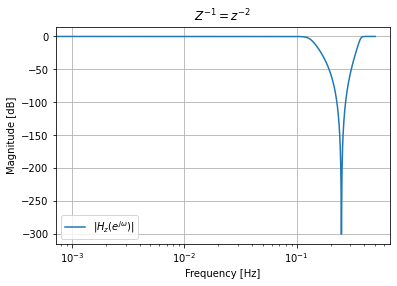

In [134]:
def second_transf_zpk(z, p, k):
    z = np.sqrt(z)
    z = np.concatenate([z, -z])

    p = np.sqrt(p)
    p = np.concatenate([p, -p])

    return z, p, k

def second_transf_tf(b, a):
    newList = []
    for idx, val in enumerate(b):
        newList.append(val)
        newList.append(0)
    b1 = np.array(newList[:-1])
    newList = []
    for idx, val in enumerate(a):
        newList.append(val)
        newList.append(0)
    a1 = np.array(newList[:-1])

    return b1, a1

filts_tf = signal.lti(*signal.butter(ordem, Wc, btype='lowpass', analog=True, output='ba'))
filtz_tf = signal.dlti(*signal.bilinear(filts_tf.num, filts_tf.den))


filtz_ft =  signal.dlti(*second_transf_tf(filtz_tf.num, filtz_tf.den))


wz, hz = signal.freqz(filtz_ft.num, filtz_ft.den)

plt.semilogx(wz*1/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.legend()
plt.title(r'$Z^{-1} = z^{-2}$')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

# Transformação $Z^{-1} = -z^{-2}$

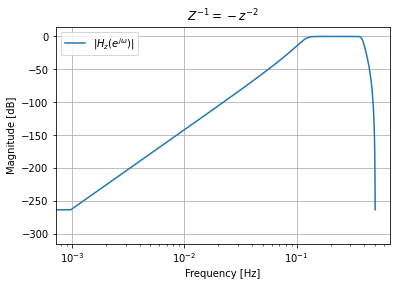

In [136]:
def third_transf_zpk(z, p, k):
    z = np.sqrt(-z)
    z = np.concatenate([z, -z])

    p = np.sqrt(-p)
    p = np.concatenate([p, -p])

    return z, p, k

def third_transf_tf(b, a):
    b_1, a_1 = first_transf_tf(b, a)
    b_2, a_2 = second_transf_tf(b_1, a_1)
    return b_2, a_2


filts_tf = signal.lti(*signal.butter(ordem, Wc, btype='lowpass', analog=True, output='ba'))
filtz_tf = signal.dlti(*signal.bilinear(filts_tf.num, filts_tf.den))

filtz_ft = signal.dlti(*third_transf_tf(filtz_tf.num, filtz_tf.den))

wz, hz = signal.freqz(filtz_ft.num, filtz_ft.den)

plt.semilogx(wz*1/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.legend()
plt.title(r'$Z^{-1} = -z^{-2}$')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()


In [ ]:
import wave

wf = wave.open('Explosion-1.wav')
channels = wf.getnchannels()
sampwidth = wf.getsampwidth()
framerate = wf.getframerate()
nframes = wf.getnframes()
frames = wf.readframes(441000)

out = np.frombuffer(frames, dtype=np.uint16)

newFrames = out.tobytes()

wfo = wave.open('exit.wav', 'wb')
wfo.setnchannels(channels)
wfo.setsampwidth(sampwidth)
wfo.setframerate(framerate)
wfo.writeframes(newFrames)